In [2]:
import cv2
import imutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import gdown as gdown
import zipfile

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

In [3]:
from Models import *

In [4]:
PATH = os.getcwd()
letterToNumber = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}
numberToLetter = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [12]:
# Descarga los modelos entrenados
url =  'https://drive.google.com/uc?id=1PGKJ4GU9yI1JVVddAtvuyhyPfL719BUG&export=download'
output = 'models.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile("models.zip","r") as zip_ref:
    zip_ref.extractall(PATH)

In [5]:
#Obtener images = lista de np arrays que entran al modelo
img = cv2.imread(PATH + '/hand1.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
mask = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)
conts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
conts = imutils.grab_contours(conts)
boxes = []
for cntr in conts:
    x,y,w,h = cv2.boundingRect(cntr)
    boxes.append((x,y,w,h))

boxes = sorted(boxes, key=lambda x: (x))

images = []
for i in boxes:
    x = i[0]
    y = i[1]
    w = i[2]
    h = i[3]
    cropped = gray[y:y+h, x:x+w]
    cropped = 255 - cropped
    cropped = cv2.resize(cropped, (28, 28))
    images.append(cropped)    
    #plt.imshow(cropped)
    #plt.show()
print(len(images))
print(type(images[0]))
print(images[0].shape)

13
<class 'numpy.ndarray'>
(28, 28)


In [6]:
# Carga el modelo y lo envia a device
model = torch.load(PATH + '/Lenet5_1_fc.pt')
model = model.to(device)
model.eval()

Lenet5_1_fc(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=(5, 5))
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=400, out_features=26, bias=True)
  )
)

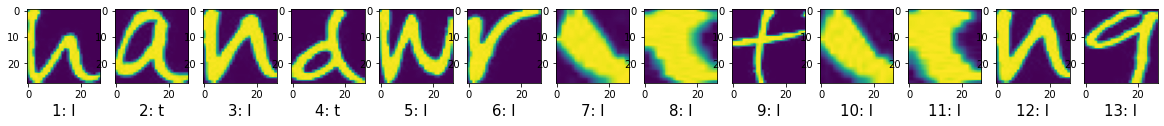

In [7]:
#Testea
transformToTensor = transforms.ToTensor()
imageTensors = [transformToTensor(np.array(img)) for img in images]
imageBatch = torch.utils.data.DataLoader(dataset=imageTensors, batch_size=64, shuffle=False)

batch = 0
for imgBatch in imageBatch:
    imgBatch = imgBatch.to(device)
    labelBatchPred = model(imgBatch)
    
    labelBatchPred = labelBatchPred.to('cpu')
    imgBatch = imgBatch.to('cpu')
    #print(labelBatchPred[0])
    _, predBatch = torch.max(labelBatchPred, 1)
    
    group = 0
    n = len(imgBatch)
    ok = 1
    while(group < 4 and ok):
        plt.figure(figsize = (25, 10))
        r, c = 1, 16
        for i in range(16):
            plt.subplot(r, c, i+1)
            plt.imshow(imgBatch[16*group + i].permute(1, 2, 0))
            plt.xlabel(str(64*batch + 16*group + i + 1) + ": " + numberToLetter[predBatch[16*group + i].item()], fontsize = 15)
            if 16*group + i + 1 == n:
                ok = 0
                break
        plt.show()
        print("")
        group += 1
    batch += 1

In [150]:
import cv2
import time

def initiate_camera(seconds, out_name):
    st = time.time()
    iteration = 0

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("Cannot open webcam")

    while True:
        ret, frame = cap.read()
        # frame = cv2.resize(frame, None, fx = 0.5, fy = 0.5, interpolation=cv2.INTER_AREA)
        cv2.imshow('Input', frame)
        cur_time = time.time()
        elapsed_time = cur_time - st

        if elapsed_time > iteration * seconds:
            cv2.imwrite(out_name, frame)
            iteration += 1
            #Aquí debería ir el código que manda la imagen (frame) al separador de letras.
            #frame contiene la imagen como valor, y la imagen capturada como archivo se guarda en out_name
        c = cv2.waitKey(1)
        if c == 27:
            break
    cap.release()
    cv2.destroyAllWindows()


#initiate_camera(5, "out.jpg")

KeyboardInterrupt: 